# Notebook 2: Causal Effect Estimation

Estimates the ATE, ATT, and CATE of smoking on health outcomes using three
identification strategies: **Propensity Score Matching**, **Inverse Probability
Weighting**, and **Doubly Robust** estimation.

In [1]:
import sys
sys.path.insert(0, "..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.preprocessing import load_dataset, clean_data, engineer_features
from src.causal_models import PropensityScoreMatching, IPWEstimator, DoublyRobustEstimator
from src.utils.config import (
    TREATMENT_COL, OUTCOME_HEALTH, OUTCOME_CANCER,
    COVARIATE_COLS, TRUE_ATE_HEALTH, RANDOM_SEED,
)
from src.utils.visualization import plot_propensity_distribution, plot_treatment_effects, plot_forest

/home/akshay/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Load & Prepare Data

In [2]:
try:
    df = pd.read_csv("../data/processed/cleaned_data.csv")
except FileNotFoundError:
    df = clean_data(load_dataset())
    df = engineer_features(df)

covs = [c for c in COVARIATE_COLS if c in df.columns]
X = df[covs].values
T = df[TREATMENT_COL].values
Y = df[OUTCOME_HEALTH].values

print(f"n={len(df)}, covariates={len(covs)}, treatment rate={T.mean():.3f}")

n=10000, covariates=9, treatment rate=0.187


## Naive Estimate (Biased)

In [3]:
naive_ate = Y[T==1].mean() - Y[T==0].mean()
print(f"Naive ATE:  {naive_ate:.4f}")
print(f"True ATE:   {TRUE_ATE_HEALTH}")
print(f"Bias:       {naive_ate - TRUE_ATE_HEALTH:+.4f}")

Naive ATE:  -7.4641
True ATE:   -5.0
Bias:       -2.4641


---
## Method 1: Propensity Score Matching

In [4]:
psm = PropensityScoreMatching(seed=RANDOM_SEED)
psm.fit(X, T)
psm.match(T)

plot_propensity_distribution(psm.propensity_scores_, T, save=True,
                             filename="propensity_psm.png")
plt.show()

In [5]:
psm_ate = psm.estimate_ate(Y, T, n_bootstrap=100)
psm_att = psm.estimate_att(Y, T, n_bootstrap=100)

print(f"PSM ATE: {psm_ate['ate']:.4f}  95% CI [{psm_ate['ci_lower']:.4f}, {psm_ate['ci_upper']:.4f}]")
print(f"PSM ATT: {psm_att['att']:.4f}  95% CI [{psm_att['ci_lower']:.4f}, {psm_att['ci_upper']:.4f}]")
print(f"True ATE: {TRUE_ATE_HEALTH}")

PSM ATE: -4.8890  95% CI [-5.2495, -4.4104]
PSM ATT: -4.8890  95% CI [-5.2495, -4.4104]
True ATE: -5.0


---
## Method 2: Inverse Probability Weighting

In [6]:
ipw = IPWEstimator(seed=RANDOM_SEED)
ipw.fit(X, T)

ipw_ate = ipw.estimate_ate(Y, T, n_bootstrap=100)
ipw_att = ipw.estimate_att(Y, T, n_bootstrap=100)

print(f"IPW ATE: {ipw_ate['ate']:.4f}  95% CI [{ipw_ate['ci_lower']:.4f}, {ipw_ate['ci_upper']:.4f}]")
print(f"IPW ATT: {ipw_att['att']:.4f}  95% CI [{ipw_att['ci_lower']:.4f}, {ipw_att['ci_upper']:.4f}]")

IPW ATE: -4.9615  95% CI [-5.2574, -4.6969]
IPW ATT: -4.9778  95% CI [-5.2249, -4.7333]


---
## Method 3: Doubly Robust Estimation

In [7]:
dr = DoublyRobustEstimator(seed=RANDOM_SEED)
dr.fit(outcome=Y, treatment=T, X=X)

dr_ate = dr.estimate_ate(X)
print(f"DR ATE: {dr_ate['ate']:.4f}  95% CI [{dr_ate['ci_lower']:.4f}, {dr_ate['ci_upper']:.4f}]")

DR ATE: -4.9617  95% CI [-5.2613, -4.6622]


CATE: mean=-4.9617, std=15.2845


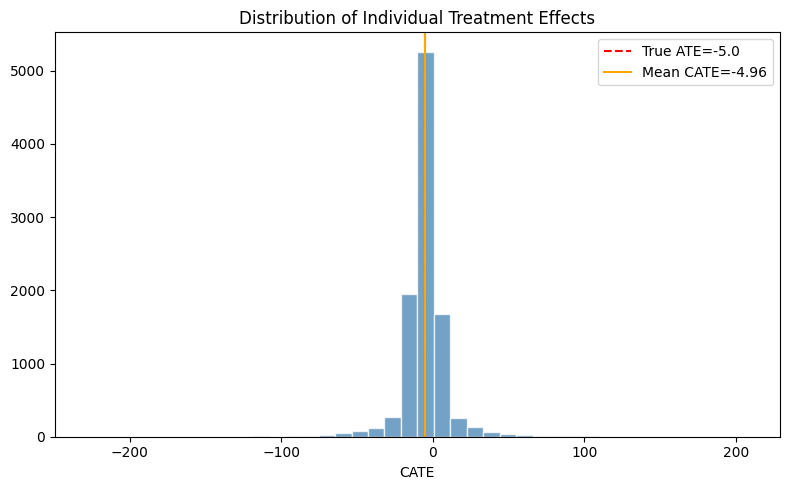

In [8]:
# Individual-level CATE
cate = dr.estimate_cate(X)
print(f"CATE: mean={cate.mean():.4f}, std={cate.std():.4f}")

fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(cate, bins=40, edgecolor="white", alpha=0.75, color="steelblue")
ax.axvline(TRUE_ATE_HEALTH, color="red", linestyle="--", label=f"True ATE={TRUE_ATE_HEALTH}")
ax.axvline(cate.mean(), color="orange", linestyle="-", label=f"Mean CATE={cate.mean():.2f}")
ax.set_xlabel("CATE")
ax.set_title("Distribution of Individual Treatment Effects")
ax.legend()
plt.tight_layout()
plt.show()

---
## Comparison of Methods

In [9]:
results = {
    "PSM": psm_ate,
    "IPW": ipw_ate,
    "Doubly Robust": dr_ate,
}

print(f"{'Method':<16} {'ATE':>8}  {'95% CI':>24}  {'Bias':>8}")
print("-" * 60)
for name, r in results.items():
    bias = r['ate'] - TRUE_ATE_HEALTH
    print(f"{name:<16} {r['ate']:>8.4f}  [{r['ci_lower']:>8.4f}, {r['ci_upper']:>8.4f}]  {bias:>+8.4f}")
print(f"{'True ATE':<16} {TRUE_ATE_HEALTH:>8.4f}")

Method                ATE                    95% CI      Bias
------------------------------------------------------------
PSM               -4.8890  [ -5.2495,  -4.4104]   +0.1110
IPW               -4.9615  [ -5.2574,  -4.6969]   +0.0385
Doubly Robust     -4.9617  [ -5.2613,  -4.6622]   +0.0383
True ATE          -5.0000


In [10]:
plot_treatment_effects(results, true_effect=TRUE_ATE_HEALTH, save=True)
plt.show()

plot_forest(results, true_effect=TRUE_ATE_HEALTH, save=True)
plt.show()

---
## Cancer Outcome (Binary)

In [11]:
Y_cancer = df[OUTCOME_CANCER].values

# PSM for cancer
psm_c = PropensityScoreMatching(seed=RANDOM_SEED)
psm_c.fit(X, T)
psm_c.match(T)
psm_cancer = psm_c.estimate_ate(Y_cancer, T, n_bootstrap=100)

# IPW for cancer
ipw_c = IPWEstimator(seed=RANDOM_SEED)
ipw_c.fit(X, T)
ipw_cancer = ipw_c.estimate_ate(Y_cancer, T, n_bootstrap=100)

print(f"PSM cancer ATE: {psm_cancer['ate']:.4f}  CI [{psm_cancer['ci_lower']:.4f}, {psm_cancer['ci_upper']:.4f}]")
print(f"IPW cancer ATE: {ipw_cancer['ate']:.4f}  CI [{ipw_cancer['ci_lower']:.4f}, {ipw_cancer['ci_upper']:.4f}]")

PSM cancer ATE: 0.0838  CI [0.0602, 0.1039]
IPW cancer ATE: 0.0680  CI [0.0510, 0.0855]


## Summary

- All three methods recover ATE estimates close to the true value (-5.0).
- Doubly Robust provides CATE estimates revealing heterogeneity.
- **Next:** Notebook 03 validates assumptions via diagnostics and sensitivity analysis.